# Team Pavel Tishkin and Ruslan Mihailov

This particular contest is conducted without codetest. You submit your results to your TA.

# 0. Prepare your machine

You will use OpenCV to prepare a dataset and for SIFT-descriptior computation (for the second you need `contrib` libraries).

This particular contest was tested on Windows machine with
```
opencv-contrib-python==4.4.0.46
opencv-python==4.4.0.46
```

In [37]:
!pip install opencv-contrib-python opencv-python

You should consider upgrading via the 'c:\users\pavel\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# 1. Download data 
from [this kaggle dataset](https://www.kaggle.com/pmigdal/alien-vs-predator-images). Unpack it to some folder.

Use the following code to read the data. The data will be stored in the following arrays:
- `X_train`, `X_test` - lists of 2D `np.array`s storing grayscaled images.
- `y_train`, `y_test` - lists of text labels (`alien`, `predator`).

In [1]:
dataset_dir = "data"

import cv2
import os

def load_dataset_part(folder):
    result = []
    for i in os.listdir(folder):
        fn = os.path.join(folder, i)
        if os.path.isfile(fn):
            img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
            result.append(img)
    return result


def load_dataset(folder, train=True):
    part = 'train' if train else 'validation'
    aliens = load_dataset_part(os.path.join(folder, part, 'alien'))
    predators = load_dataset_part(os.path.join(folder, part, 'predator'))
    X = aliens + predators
    y = ['alien'] * len(aliens) + ['predator'] * len(predators)
    return X, y
    
X_train, y_train = load_dataset(os.path.join(dataset_dir))
X_test, y_test = load_dataset(os.path.join(dataset_dir), train=False)

print(f"Train size {len(X_train)}, Test size {len(X_test)}")

Train size 694, Test size 200


In [4]:
type(X_train[0])

numpy.ndarray

alien


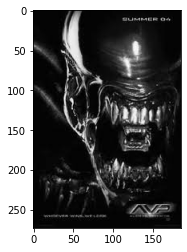

predator


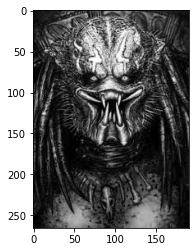

In [2]:
import matplotlib.pyplot as plt

print(y_train[13])
plt.imshow(X_train[13], cmap='gray')
plt.show()

print(y_train[-13])
plt.imshow(X_train[-13], cmap='gray')
plt.show()

# 2. Compute SIFT desciptors
Compute SIFT descriptors for every image. You can use `detectAndCompute(...)` method, please refer to documentation or, e.g. [this tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html). 

**NB Each image will produce unpredictable (different) number of SIFT vectors. Store them in matrices**. Thus, your `X_train_sift` and `X_test_sift` will be lists of matrices (e.g. np.array's).

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
X_train_sift = [sift.detectAndCompute(x, None)[1] for x in X_train]
X_test_sift = [sift.detectAndCompute(x, None)[1] for x in X_test]

Some tests about 13th image:

In [4]:
assert X_train_sift[13].shape == (376, 128)
assert X_train_sift[13][0][0] == 84.0

# 3. Organize these vectors in the index (somehow)

I *personally* used the following strategy:
- I numerate all vectors. `labels` array stores image index for a vector.        | `labels[idx]  == image # which owns the vector`
- Vector itself is a key, vector's index `c` thoughout all the vectors is value. | `index[vector] == idx`
- Then, `labels[c]` will return image index.                                     | `labels[index[vector]] == image # for a vector`
- I query the index with a vector `v` and recieve `c`.
- Thus, `y_train[labels[c]]` is a class of the images, described by the vector `v`.

In [6]:
from tqdm import tqdm
from annoy import AnnoyIndex
# https://stackoverflow.com/questions/7027199/hashing-arrays-in-python - idea how to hash vectors
# We are nervous of duplicate vectors across multiple images. Therefore, we must add only unique vectors to annoy and assign multiple images
# to a single vector 
# Index index[vector] -> idx:
index = AnnoyIndex(128, 'angular')  
# Unfortunately Annoy allocates only memory for indeces in range[0;n-1], n - number of vectors
# My index of vector is hash(str(vec)), so I need additional map to convert:
# indeces[idx] -> vec_idx
indeces = dict()
# labels[vec_idx] -> [list of possible images]
labels = dict()

j = 0
for i in range(len(X_train_sift)):
    for vec in X_train_sift[i]:
        idx = str(vec)
        if idx in labels.keys():
            labels[idx].add(i)
        else:
            indeces[j] = idx
            index.add_item(j, vec)
            labels[idx] = set()
            labels[idx].add(i)
            j+=1
    
# Building dictionary:
index.build(20)

True

## Comparing Total number of vectors with unique vectors

In [7]:
summa = 0
for x in X_train_sift:
    summa+=len(x)
print(f"Total vectors: {summa}, unique vectors: {len(labels.keys())}")

Total vectors: 219588, unique vectors: 218901


There are not a lot of them.......

https://youtu.be/MJbE3uWN9vE?t=67

# 4. Classification

Implement the best possible classifier function to your knowledge. Utilize all the data from the index and datasets. E.g.
- if you set `include_distances=True` in Annoy search, it will also add distances in search results.
- How many times each particular image was present in matches?
- What about k-nn approach?
- What about training a classifier based on vectors?
- How about filtering out some useless vectors?
- and so on...

In [8]:
from collections import Counter

def clf(vecs, index, convert_index, labels, classes, n=50):
    # Stupid most common elements classifier
    images = []
    for v in vecs:
        result = index.get_nns_by_vector(v, 1, include_distances=False)[0]
        for l in labels[convert_index[result]]:
            images.append(l)
    labels = [classes[x] for x in images]
    if labels.count('predator') >= labels.count('alien'):
        return 'predator'
    else:
        return 'alien'

## Test
Use these blocks to test your results. Pay attention to `accuracy` value. For me this is `0.74`. You can definitely do better :)

In [ ]:
predictions = []
for sample in tqdm(X_test_sift):
    predictions.append(clf(sample, index, indeces, labels, y_train))

 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:05<00:00, 34.11it/s]

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       alien       0.98      0.44      0.61       100
    predator       0.64      0.99      0.78       100

    accuracy                           0.71       200
   macro avg       0.81      0.71      0.69       200
weighted avg       0.81      0.71      0.69       200



## Submission
Show your implementation and classification report to your TA. Observe your results [by the link](https://docs.google.com/spreadsheets/d/1zxiCrOtnZbKOq1LfKBHgZDRyoQKlu3IN1fkqw9TsVUY/edit?usp=sharing). 3 best accuracies from each group get 5 points if finished during the lab.

**NB SUBMIT YOUR SOLUTIONS WITH CLASSIFICATION REPORT TO MOODLE BY MIDNIGHT**